In [1]:
import cluster_model

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = 'EleutherAI/pythia-70m'
DATASET_NAME = 'NeelNanda/pile-10k'
MIXTURE_MODEL_TYPE = "KMenas"
# 
N_DIMS = 512
SEED = 69_420
# 
DEBUG = False
# 
if DEBUG:
    N_DATASIZE = 200
    N_CLUSTERS_MIN = 20
    N_CLUSTERS_MAX = 21
    N_BLOCKS = 6
    STRING_SIZE_CUTOFF = 200
else:
    # It gets killed aroun 1_800 idk why. Maybe we have a problem with token truncation somewhere
    N_DATASIZE = 1_800
# 
    # N_CLUSTERS_MIN = int(0.5 * N_DIMS)
    # N_CLUSTERS_MAX = 10 * N_DIMS
    # TODO: DEL ME
    N_CLUSTERS_MIN = N_DIMS
    N_CLUSTERS_MAX = N_DIMS + 1
    N_BLOCKS = 6
    STRING_SIZE_CUTOFF = 1_200

params = cluster_model.InterpParams(
	lattice_params=cluster_model.LatticeParams(
		top_layer_idx = -1,
        max_n_parents = 4
	),
    # quantization='4bit',
	seed=SEED,
    n_datasize=N_DATASIZE,
    n_blocks=N_BLOCKS,
    model_name=MODEL_NAME,
	model_n_dims=N_DIMS,
    dataset_name=DATASET_NAME,
    string_size_cutoff=STRING_SIZE_CUTOFF,
)

decomp = cluster_model.Decomposer(params)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda
Creating decomposer with parameter data hash metadata/data-63f605fb4a8ab2a4def8c769bde1b72748e21f54/start.pkl
Creating decomposer with parameter lattice hash metadata/correlation-de5f2c593b55f095d11e400fd8f6d0964dc8512c/start.pkl
Created dataset
Loading dataset from cache
Got embeddings


In [3]:
decomp.load()

Loading cluster scores from cache


In [4]:
decomp.correlation_scores

[array([[ 0.64046962, -0.64046962,  0.00729502, ..., -0.04974159,
         -0.01168576,  0.01168576],
        [-0.64046962,  0.64046962, -0.00729502, ...,  0.04974159,
          0.01168576, -0.01168576],
        [-0.04254546,  0.04254546,  0.64492699, ...,  0.02710765,
          0.02147841, -0.02147841],
        ...,
        [-0.10489588,  0.10489588, -0.01329932, ...,  0.5548627 ,
         -0.05499111,  0.05499111],
        [ 0.0150932 , -0.0150932 , -0.03359263, ..., -0.01325325,
          0.55551817, -0.55551817],
        [-0.0150932 ,  0.0150932 ,  0.03359263, ...,  0.01325325,
         -0.55551817,  0.55551817]]),
 array([[ 0.61450631, -0.61450631, -0.03994924, ..., -0.01211377,
         -0.00437635,  0.00437635],
        [-0.61450631,  0.61450631,  0.03994924, ...,  0.01211377,
          0.00437635, -0.00437635],
        [-0.04855229,  0.04855229,  0.52611977, ..., -0.02763018,
         -0.00102654,  0.00102654],
        ...,
        [-0.0277824 ,  0.0277824 ,  0.01654728, ...,  

In [5]:
from typing import List
import importlib
import utils
importlib.reload(utils)
modified_lattice = decomp.correlation_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.correlation_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

0.0
0.0


## Isolate Specific Neurons

In [6]:
LAYER = 0
NEURON = 128

In [7]:
import numpy as np
import kernel
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
import graph
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(graph)
importlib.reload(kernel)

N_CHECK = 4

# decomp.scores_for_neuron(LAYER, NEURON, n_features_per_neuron=3)

/tmp/ipykernel_82359/2553305548.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

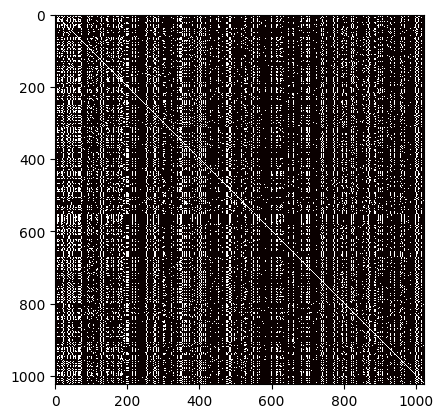

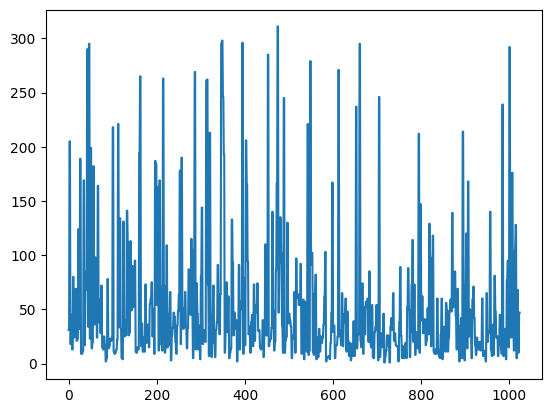

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 4
cutoff = 0.1

# ax = sns.heatmap(decomp.correlation_scores[LAYER_START])
plt.imshow((decomp.correlation_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.correlation_scores[3] > cutoff).sum(axis=1))

## Get scores for layers

In [9]:
decomp.scores_for_layer(1)

WEIGHTING PER LAYER [0.5    1.     0.5    0.25   0.125  0.0625]
EDGE DISCOVERY WEIGHTING PER LAYER [0.8    0.8    0.64   0.512  0.4096]
Getting top 20 paths
([582, 0, 957, 957, 957, 957], 0.8548536258890995)
([502, 0, 957, 957, 957, 957], 0.8501176258890996)
([582, 0, 315, 315, 315, 395], 0.8511180738890995)
([582, 0, 315, 315, 315, 346], 0.8495247298890996)
([502, 0, 315, 315, 315, 395], 0.8463820738890995)
([582, 0, 47, 315, 315, 395], 0.8465820738890995)
([582, 0, 315, 315, 315, 474], 0.8482262978890995)
([582, 0, 315, 315, 315, 660], 0.8478166978890995)
([502, 0, 315, 315, 315, 346], 0.8447887298890995)
([894, 0, 957, 957, 957, 957], 0.8315016258890995)
([582, 0, 47, 315, 315, 346], 0.8449887298890995)
([65, 0, 957, 957, 957, 957], 0.8301256258890995)
([502, 0, 47, 315, 315, 395], 0.8418460738890995)
([502, 0, 315, 315, 315, 474], 0.8434902978890995)
([593, 0, 957, 957, 957, 957], 0.8292616258890995)
([582, 0, 47, 315, 315, 474], 0.8436902978890994)
([502, 0, 315, 315, 315, 660], 0

FileNotFoundError: [Errno 2] No such file or directory: 'metadata/data-de5f2c593b55f095d11e400fd8f6d0964dc8512c/layer_1_neuron_0.json'